# Almond Classification Model

# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import chi2_contingency, f_oneway, anderson
import scipy.stats as stats


from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [5]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/Almond.csv")
df

,Unnamed: 0,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,2798,NaN,192.709366,122.356506,18471.5,653.345233,NaN,0.931000,1.838965,NaN,NaN,0.725739,19840.5,SANORA
2799,2799,NaN,186.254745,118.708961,17213.5,581.688379,NaN,0.952706,1.564234,NaN,NaN,0.714016,18068.0,SANORA
2800,2800,NaN,186.196182,119.147224,17510.5,608.315795,NaN,0.948821,1.681705,NaN,NaN,0.718999,18455.0,SANORA
2801,2801,NaN,188.660828,120.634438,17941.0,630.759446,NaN,0.944810,1.764701,NaN,NaN,0.738191,18989.0,SANORA


In [3]:
df.drop("Unnamed: 0", axis=1, inplace=True)

# Check Class Imbalance

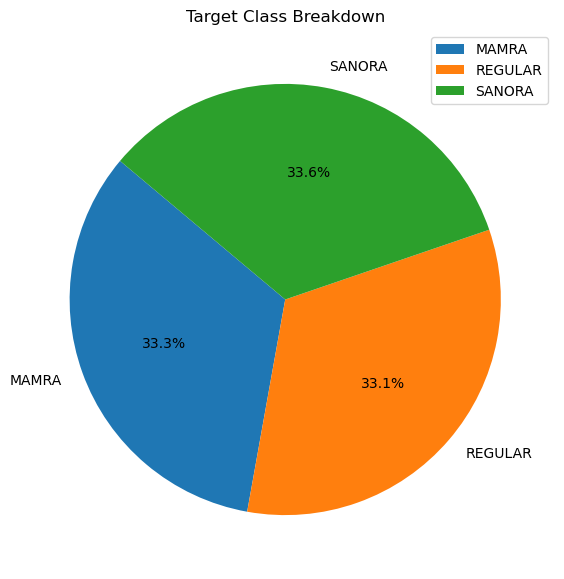

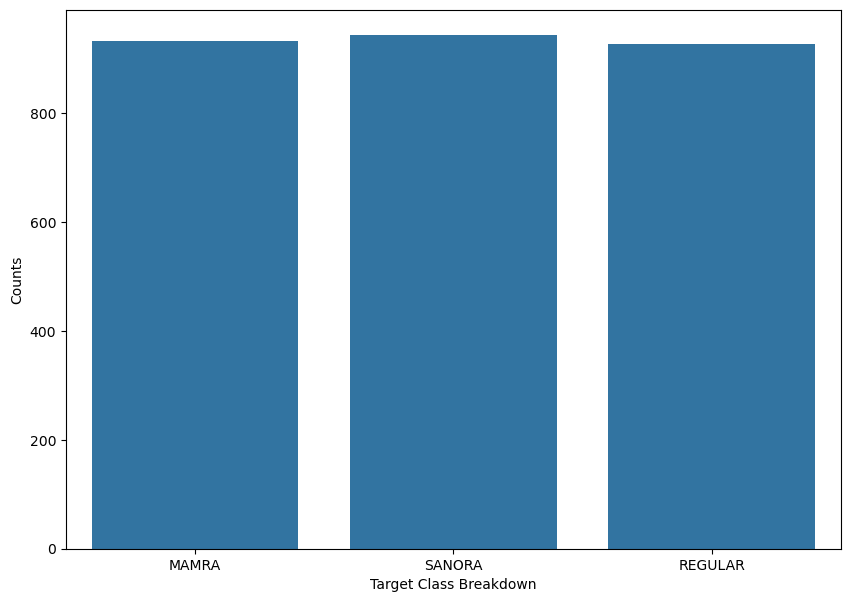

In [6]:
check_class_imbalance(df["Type"])

In [7]:
check_for_nulls_dupes(df)

The amount of Null Values: Length (major axis)          857
Width (minor axis)           942
Thickness (depth)           1004
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64
The amount of Duplicated Values 3


In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.describe()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area)
count,1944.000000,1859.000000,1797.000000,2800.000000,2800.000000,1944.000000,2800.000000,2800.000000,1003.000000,1003.000000,2800.000000,2800.000000
mean,290.477086,171.037676,109.727607,26503.354107,743.573293,0.470611,0.955919,1.823211,1.752777,0.813038,0.724664,27686.578750
std,62.610007,29.896653,18.938723,13763.416459,230.367902,0.118604,0.039358,0.789515,0.206252,0.041261,0.047410,14215.481045
min,151.335266,88.050529,59.494278,6037.000000,311.563489,0.173748,0.718772,1.164469,1.400082,0.699897,0.454538,6355.000000
25%,245.916424,149.477875,97.267624,16214.000000,571.552339,0.385183,0.944733,1.357361,1.612441,0.784461,0.701889,17093.500000
50%,279.871277,170.168365,110.289268,23421.000000,707.144223,0.473275,0.970482,1.576375,1.705669,0.810108,0.733778,24581.000000
75%,330.273262,190.612556,121.393219,33448.000000,878.825462,0.577628,0.981490,1.963977,1.833105,0.838096,0.757594,34862.875000
max,515.352478,258.569794,181.845200,89282.000000,1864.947387,0.697293,0.992889,9.660057,2.731251,0.930563,0.845813,90642.500000


# We Will have to plug in all of this missing data with either the mean, median or a prediction model. We Will test numerous choices